In [101]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import gpflow as gpf
import time

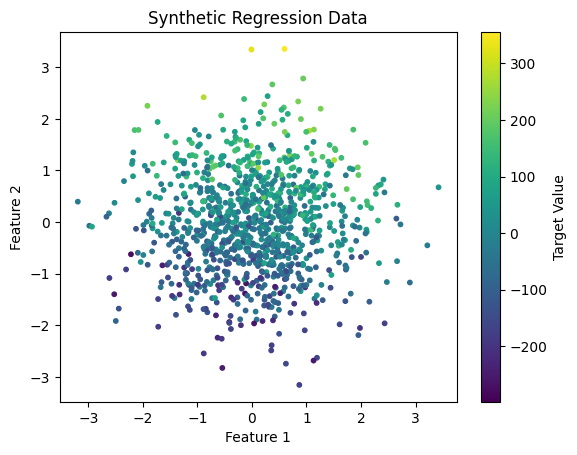

In [102]:
# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=5, noise=0.1)

# Plot the first two dimensions of the data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=10)
plt.title('Synthetic Regression Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Target Value')
plt.show()

In [103]:
# Function to train a GP model and return the RMSE, average uncertainty, and time taken for inversion
def train_and_evaluate_gp(n_samples, model, Kernel):
    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=0.1)  # n_features=1 for plotting
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert to TensorFlow tensors
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float64)
    y_train = tf.convert_to_tensor(y_train.reshape(-1, 1), dtype=tf.float64)  # Make y_train a column vector
    
    # Create a GP regression model with an RBF kernel
    if model == "GPR":
        model = gpf.models.GPR(data=(X_train, y_train), kernel=Kernel, mean_function=None)
    elif model == "SGPR":
        inducing_variables = tf.gather(X_train, tf.random.shuffle(tf.range(tf.shape(X_train)[0]))[:tf.shape(X_train)[0] // 10])
        model = gpf.models.SGPR(data=(X_train, y_train), kernel=Kernel, inducing_variable=inducing_variables, mean_function=None)
        
    
    # Measure the time taken to optimize (which includes matrix inversion)
    start_time = time.time()
    
    # Optimize the model's parameters
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    
    end_time = time.time()
    
    # Time taken for matrix inversion and optimization
    time_taken = end_time - start_time
    
    # Make predictions on the test set
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float64)
    mean, variance = model.predict_f(X_test)
    
    # Convert predictions to NumPy arrays
    mean_np = mean.numpy().flatten()
    variance_np = variance.numpy().flatten()
    y_test_np = y_test.flatten()
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((mean_np - y_test_np) ** 2))
    
    # Compute average uncertainty (standard deviation)
    avg_uncertainty = np.mean(np.sqrt(variance_np))
    
    return rmse, avg_uncertainty, time_taken

In [104]:
##Train and evaluate different GPS 
def run_comparison(max_samples, model, kernel):
    
        # List of dataset sizes to evaluate, starting from 10 and doubling each time
    start = 100
    #Run on 20 samples
    step = (max_samples - start) // 20
    dataset_sizes = np.arange(start, max_samples + 1, step)
    print(max(dataset_sizes))

    # Store the results
    rmses = []
    uncertainties = []
    times = []

    # Loop over each dataset size
    for idx, size in enumerate(dataset_sizes):
        rmse, avg_uncertainty, time_taken = train_and_evaluate_gp(size, model, kernel)
        rmses.append(rmse)
        uncertainties.append(avg_uncertainty)
        times.append(time_taken)
        print(f"Dataset size: {size}, RMSE: {rmse:.4f}, Avg. Uncertainty: {avg_uncertainty:.4f}, Time: {time_taken:.4f} seconds")

    # Complexity analysis
    # The time complexity of training a GP model is O(N^3), where N is the number of data points.
    for idx, size in enumerate(dataset_sizes):
        if idx > 0:
            ratio = times[idx] / times[idx - 1]
            print(f"Time ratio for dataset size {size}: {ratio:.4f}")
    # Plot the results
    plt.figure(figsize=(10, 6))

    # Plot RMSE history
    plt.subplot(3, 1, 1)
    plt.plot(dataset_sizes, rmses, 'o-', label='RMSE')
    plt.title('RMSE, Uncertainty, and Time vs Dataset Size')
    plt.ylabel('RMSE')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Plot uncertainty history
    plt.subplot(3, 1, 2)
    plt.plot(dataset_sizes, uncertainties, 'o-', label='Average Uncertainty', color='orange')
    plt.ylabel('Average Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Plot time history
    plt.subplot(3, 1, 3)
    plt.plot(dataset_sizes, times, 'o-', label='Time for Optimization (includes matrix inversion)', color='green')
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    return

3000
Dataset size: 100, RMSE: 0.0740, Avg. Uncertainty: 0.0169, Time: 0.4038 seconds
Dataset size: 245, RMSE: 0.0882, Avg. Uncertainty: 0.0145, Time: 0.3150 seconds
Dataset size: 390, RMSE: 0.1008, Avg. Uncertainty: 0.0091, Time: 0.3225 seconds
Dataset size: 535, RMSE: 0.0953, Avg. Uncertainty: 0.0098, Time: 0.3379 seconds
Dataset size: 680, RMSE: 0.0942, Avg. Uncertainty: 0.0063, Time: 0.3293 seconds
Dataset size: 825, RMSE: 0.1100, Avg. Uncertainty: 0.0061, Time: 0.3996 seconds
Dataset size: 970, RMSE: 0.0993, Avg. Uncertainty: 0.0066, Time: 0.5365 seconds
Dataset size: 1115, RMSE: 0.0958, Avg. Uncertainty: 0.0058, Time: 0.5118 seconds
Dataset size: 1260, RMSE: 0.0994, Avg. Uncertainty: 0.0048, Time: 0.6776 seconds
Dataset size: 1405, RMSE: 0.1036, Avg. Uncertainty: 0.0050, Time: 0.5004 seconds
Dataset size: 1550, RMSE: 0.0974, Avg. Uncertainty: 0.0048, Time: 0.6266 seconds
Dataset size: 1695, RMSE: 0.1020, Avg. Uncertainty: 0.0043, Time: 0.6806 seconds
Dataset size: 1840, RMSE: 0.10

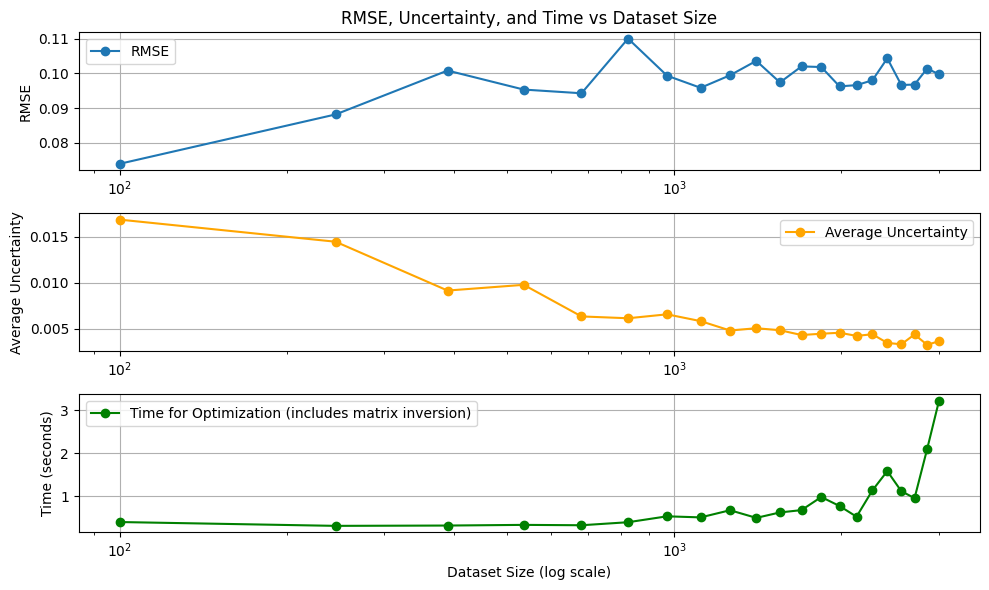

3000
Dataset size: 100, RMSE: 0.0982, Avg. Uncertainty: 0.0147, Time: 0.2376 seconds
Dataset size: 245, RMSE: 0.0798, Avg. Uncertainty: 0.0107, Time: 0.1946 seconds
Dataset size: 390, RMSE: 0.0884, Avg. Uncertainty: 0.0096, Time: 0.3428 seconds
Dataset size: 535, RMSE: 0.0867, Avg. Uncertainty: 0.0078, Time: 0.4804 seconds
Dataset size: 680, RMSE: 0.1049, Avg. Uncertainty: 0.0066, Time: 1.7645 seconds
Dataset size: 825, RMSE: 0.0939, Avg. Uncertainty: 0.0066, Time: 1.0593 seconds
Dataset size: 970, RMSE: 0.1025, Avg. Uncertainty: 0.0053, Time: 1.8076 seconds
Dataset size: 1115, RMSE: 0.1043, Avg. Uncertainty: 0.0053, Time: 2.5962 seconds
Dataset size: 1260, RMSE: 0.1063, Avg. Uncertainty: 0.0047, Time: 9.6385 seconds
Dataset size: 1405, RMSE: 0.1063, Avg. Uncertainty: 0.0048, Time: 13.5553 seconds
Dataset size: 1550, RMSE: 0.0998, Avg. Uncertainty: 0.0044, Time: 5.5879 seconds
Dataset size: 1695, RMSE: 0.0949, Avg. Uncertainty: 0.0045, Time: 4.2569 seconds
Dataset size: 1840, RMSE: 0.0

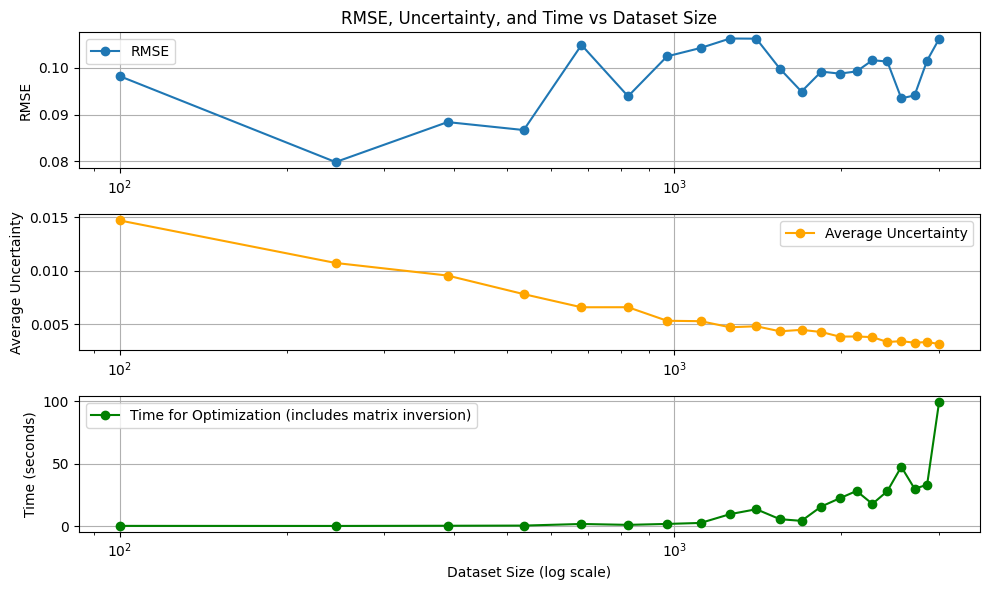

In [105]:
run_comparison(max_samples = 3000, model = "SGPR", kernel= gpf.kernels.RBF())
run_comparison(max_samples = 3000, model = "GPR", kernel= gpf.kernels.RBF())
